## Overview

This notebook demonstrates the process of training a modified ResNet-18 model on the CIFAR-10 dataset. The primary objective is to classify images into one of the 10 CIFAR-10 classes.

The study involves:

- Loading and preprocessing the CIFAR-10 dataset.
- Defining a ResNet-18 architecture adapted for smaller image sizes.
- Setting up the loss function and optimizer for training.
- Training the model for a specified number of epochs.
- Visualizing the learned filters of the first convolutional layer to gain insights into what features the network is learning early on.

## Setup and Data Loading

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define a sequence of data transformations for training images
transform_train = transforms.Compose([
    # Randomly crop images to 32x32 pixels, with 4-pixel padding on each side before cropping.
    transforms.RandomCrop(32, padding=4),
    # Randomly flip images horizontally (with a probability of 0.5) to add variety.
    transforms.RandomHorizontalFlip(),
    # Convert the PIL Image or numpy.ndarray to a PyTorch tensor (scales pixel values to [0, 1]).
    transforms.ToTensor(),
    # Normalize each channel (R, G, B) of the image tensor using CIFAR-10 dataset means and stds.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 training dataset, downloading if not present,
# and applying the transform_train pipeline to each image.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Set up a DataLoader which will provide batches of data for training:
# - Batch size of 128 (number of images per batch),
# - Shuffle the data after each epoch,
# - Use 2 subprocesses to load the data (parallelism).
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

## Data Exploration and Visualization

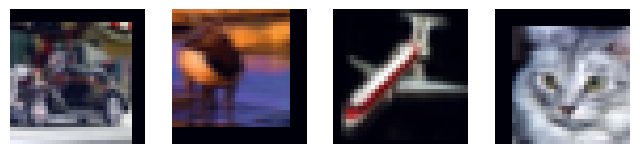

In [3]:
def show_normalized_scaled(img):
    # Convert tensor to numpy (H, W, C)
    img = img.numpy().transpose((1, 2, 0))
    # Min-max scale to [0, 1] for visualization
    img_min, img_max = img.min(), img.max()
    img = (img - img_min) / (img_max - img_min)
    plt.imshow(img)
    plt.axis('off')

# Grab a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Visualize 4 normalized images scaled for display
plt.figure(figsize=(8,2))
for i in range(4):
    plt.subplot(1, 4, i+1)
    show_normalized_scaled(images[i])
plt.show()

## Model Definition (ResNet18)

In [4]:
class ResNet18(nn.Module):
    """
    A modified ResNet-18 model tailored for small input images like CIFAR-10 (32x32).

    Key changes compared to the original ResNet-18 architecture designed for ImageNet (224x224) images:

    1. First convolution layer:
       - Changed from a 7x7 kernel with stride 2 and padding 3
         to a 3x3 kernel with stride 1 and padding 1.
       - This preserves the spatial resolution better for small images,
         avoiding excessive downsampling at the very beginning.

    2. Max pooling layer:
       - Removed the 3x3 maxpool with stride 2 by replacing it with nn.Identity().
       - This prevents early aggressive downsampling that would drastically reduce spatial size,
         which is not suitable for 32x32 inputs like CIFAR-10.

    3. Final fully connected layer:
       - Adjusted the output features to match the number of CIFAR-10 classes (default 10).
       - In the original model, this is set for 1000 ImageNet classes.

    These modifications help the model maintain sufficient spatial information throughout the network,
    improving performance on small images without changing the core ResNet block structure.
    """
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        # Load the pretrained ResNet18 model
        self.model = torchvision.models.resnet18(weights=None)
        # Adjust the first conv layer to accept CIFAR-10 input size (3x32x32)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()  # Remove the maxpool layer to preserve spatial size

        # Replace the fully connected layer to output num_classes predictions
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

## Training Setup (Loss and Optimizer)

In [5]:
# Assume model is an instance of ResNet18 and device is set (e.g., 'cuda' or 'cpu')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

Device : cuda


In [6]:
model = ResNet18(num_classes=10).to(device)

In [7]:
criterion = nn.CrossEntropyLoss()

<p>This loss function is the standard choice for multi-class classification problems like CIFAR-10 where each input belongs to exactly one of multiple classes. It combines softmax and negative log-likelihood loss in one efficient function, measuring how well the predicted class probabilities align with the true labels.</p>

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

SGD is a classical, widely used optimization algorithm for training neural networks. The momentum term (0.9 here) helps accelerate training by smoothing the gradient updates and avoiding local minima or noisy oscillations. A learning rate of 0.1 with weight decay (L2 regularization) is commonly effective for CIFAR-10 training with ResNet architectures. Weight decay helps reduce overfitting by penalizing large weights.

## Training the Model

In [9]:
def train_model(num_epochs):
  for epoch in range(num_epochs):
    model.train() # ensures model activates all training-specific behaviors correctly
    running_loss = 0.0
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()           # Clear gradients from previous step

        outputs = model(inputs)         # Forward pass
        loss = criterion(outputs, targets)  # Compute loss

        loss.backward()                 # Backward pass (compute gradients)
        optimizer.step()                # Update model parameters

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [10]:
train_model(num_epochs=10)

Epoch [1/10], Loss: 2.0507
Epoch [2/10], Loss: 1.4068
Epoch [3/10], Loss: 1.0877
Epoch [4/10], Loss: 0.8630
Epoch [5/10], Loss: 0.7249
Epoch [6/10], Loss: 0.6380
Epoch [7/10], Loss: 0.5841
Epoch [8/10], Loss: 0.5449
Epoch [9/10], Loss: 0.5152
Epoch [10/10], Loss: 0.4901


## Visualizing Learned Filters

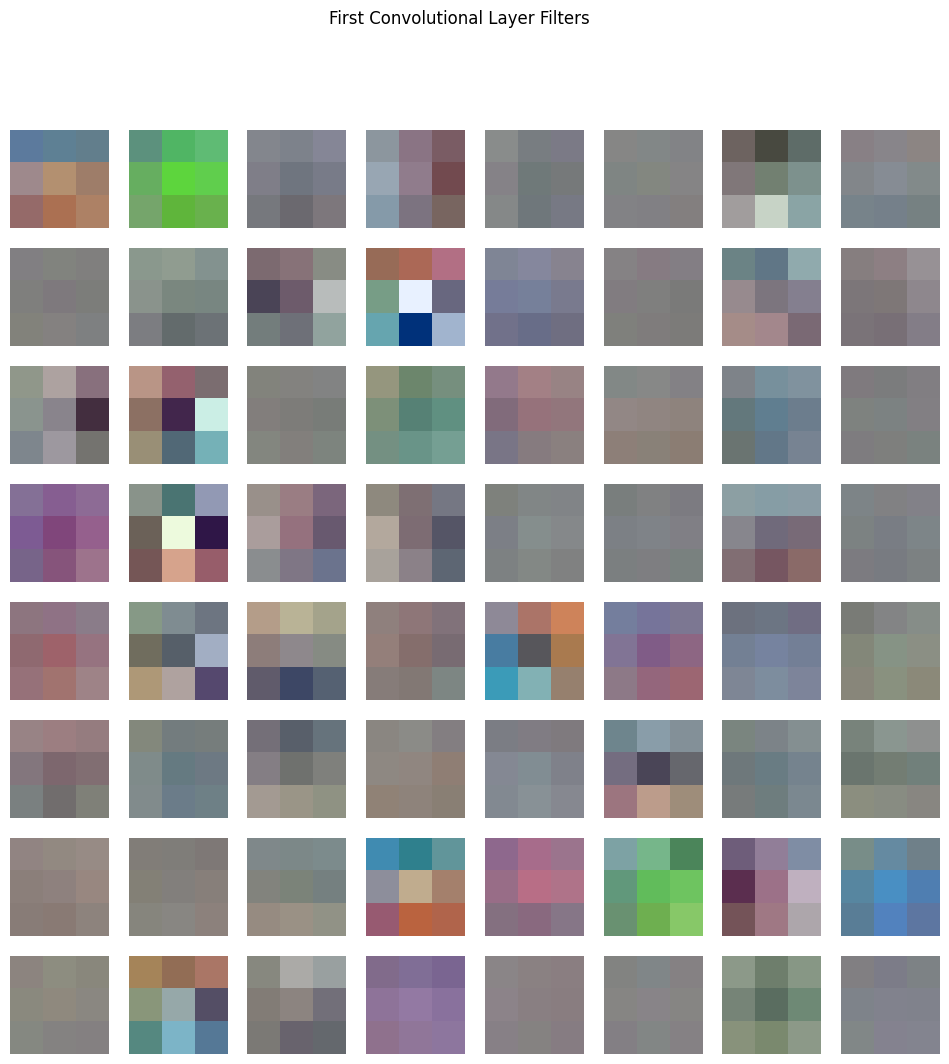

In [12]:
# Extract the weights of the first conv layer: shape (out_channels, in_channels, k, k)
filters = model.model.conv1.weight.data.cpu().numpy()

# Normalize filter values to [0, 1] for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

num_filters = filters.shape[0]

# Plot the filters
plt.figure(figsize=(12, 12)) # Adjusted figure size for 8x8 grid
for i in range(num_filters):
    plt.subplot(8, 8, i+1)  # layout: 8 rows x 8 columns for 64 filters
    # Transpose filter from (C, k, k) to (k, k, C) for displaying as image
    f = filters[i].transpose(1, 2, 0)
    plt.imshow(f)
    plt.axis('off')

plt.suptitle('First Convolutional Layer Filters')
plt.show()